Ángulo promedio de rotación: 1.00°


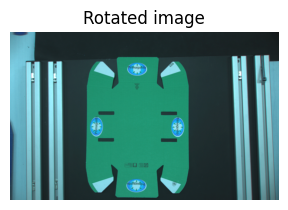

In [51]:
import cv2 as cv
import numpy as np
import os
import matplotlib.pyplot as plt


# Cargar imagen

# Get the current working directory
baseFolder = os.getcwd()

# Define the folder containing the images
folder = os.path.join(baseFolder, "photos", "diffDefect")

# Read the image in grayscale
img = cv.imread(os.path.join(folder, "4.png"))


# We load the camera calibration results (We took the photos with the first camera setup)
cameraParameters = np.load(baseFolder + "/calibration/camera_setup1.npz")

# We extract the camera matrix and distortion coefficients, through the keys in the dictionary
mtx = cameraParameters['mtx']
dist = cameraParameters['dist']
res = cameraParameters['res']


# We find the dimensions of the image
h, w = img.shape[:2]

# We find the new camera matrix and interested region
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

# We undistort the image
udst_img = cv.undistort(img, mtx, dist, None, newcameramtx)

# We crop the image using the ROI
x_r, y_r, w_r, h_r = roi
imagen = udst_img[y_r:y_r+h_r, x_r:x_r+w_r]



gris = cv.cvtColor(imagen, cv.COLOR_BGR2GRAY)
bordes = cv.Canny(gris, 50, 150, apertureSize=3)

# Detectar líneas con Hough
lineas = cv.HoughLines(bordes, 1, np.pi / 180, 200)

# Obtener ángulos de las líneas
angulos = []

for linea in lineas:
    rho, theta = linea[0]
    angulo = (theta * 180 / np.pi) - 90  # Convertimos de radianes y centramos en 0
    if -45 < angulo < 45:  # Solo tomamos líneas más horizontales
        angulos.append(angulo)

# Calcular ángulo promedio
angulo_promedio = np.mean(angulos)
print(f"Ángulo promedio de rotación: {angulo_promedio:.2f}°")

# Rotar imagen para corregir inclinación
(h, w) = imagen.shape[:2]
centro = (w // 2, h // 2)
matriz_rotacion = cv.getRotationMatrix2D(centro, angulo_promedio, 1.0)
enderezada = cv.warpAffine(imagen, matriz_rotacion, (w, h), flags=cv.INTER_CUBIC, borderMode=cv.BORDER_REPLICATE)

im_show = cv.resize(enderezada, (800,600))




plt.subplot(2,1,2)
plt.imshow(enderezada, cmap='BrBG')
plt.title("Rotated image")
plt.axis("off")
plt.show()

(1202, 1922)


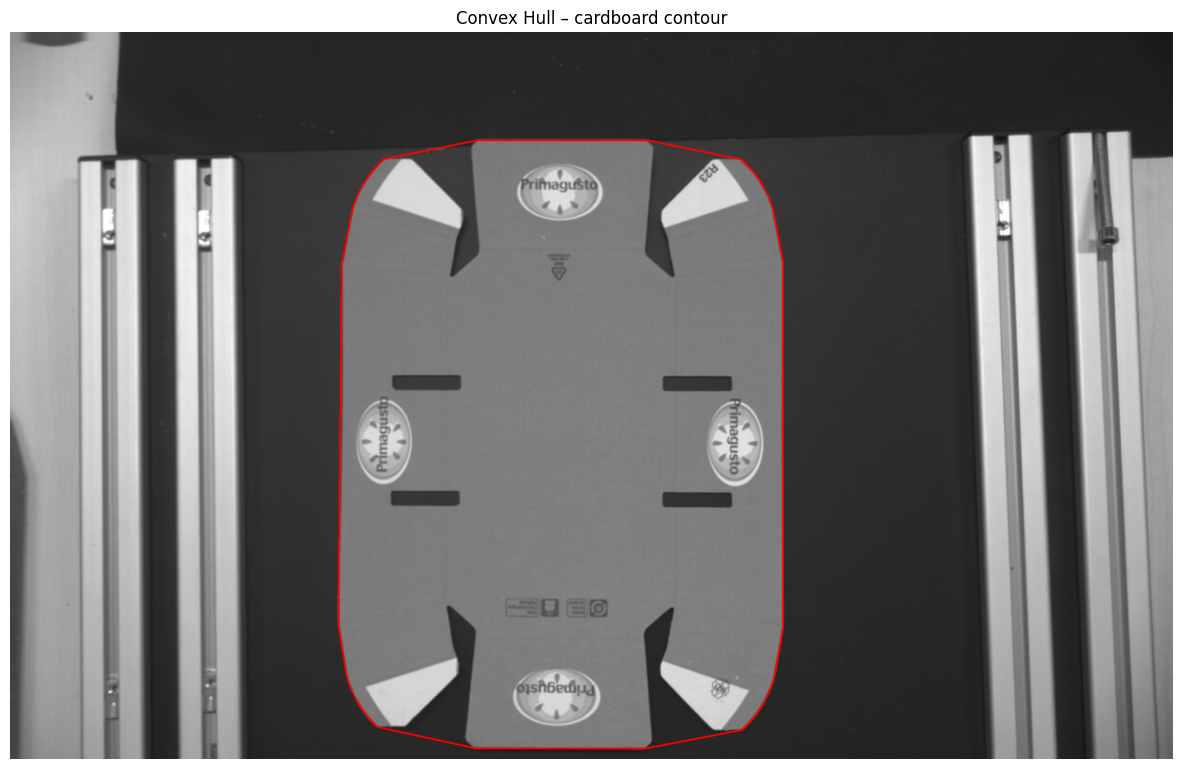

Area of the convex hull:  701147.5


In [52]:
udst_crop_img = cv.cvtColor(enderezada, cv.COLOR_BGR2GRAY)
# Thresholding the imnage OTSU gives us the optimal threshold value
_ , th_Bin_OTSU = cv.threshold(udst_crop_img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

# Let's see the results
#plt.figure(figsize=(15, 10))
#plt.imshow(th_Bin_OTSU, cmap="gray", vmin=0, vmax=255) # to complete
#plt.title("BINARY OTSU")
#plt.axis("off")

# Find the contours in the image
contours, _ = cv.findContours(th_Bin_OTSU, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# We search the biggest contour Area Based
contour_max = max(contours, key=cv.contourArea)

# Bounding box of the biggest contour
x, y, w, h = cv.boundingRect(contour_max)

# We expand the ROI
margin = 0  # Additional pixels to the ROI
x_roi = max(x - margin, 0)
y_roi = max(y - margin, 0)
w_roi = min(w + 2 * margin, th_Bin_OTSU.shape[1] - x_roi)
h_roi = min(h + 2 * margin, th_Bin_OTSU.shape[0] - y_roi)

# Draw a green rectangle using BGR
img_with_roi = cv.cvtColor(th_Bin_OTSU, cv.COLOR_GRAY2BGR)
cv.rectangle(img_with_roi, (x_roi, y_roi), (x_roi + w_roi, y_roi + h_roi), (0, 255, 0), 2)

# We show the image with the ROI detected
#plt.figure(figsize=(15, 10))
#plt.imshow(img_with_roi)
#plt.title("ROI (OTSU)")
#plt.axis("off")
#plt.show()

# We distort the image
blur = cv.GaussianBlur(udst_crop_img, (5, 5), 0)

print(blur.shape)

# We use the ROI found in the previous step
roi = blur[y_roi:y_roi+h_roi, x_roi:x_roi+w_roi]

# We apply the canny on the ROI
canny_edges_roi = cv.Canny(roi, 40, 130, L2gradient=True)
# print("Borders detected:", np.count_nonzero(canny_edges_roi))

# Dilate the edges
kernel = np.ones((2, 2), np.uint8)
canny_edges = cv.dilate(canny_edges_roi, kernel, iterations=1)

# we make a color copy of the image
img_copy = blur.copy()
img_color_copy = cv.cvtColor(img_copy, cv.COLOR_GRAY2BGR)

# We draw the edges in red on the original image
mask = canny_edges > 0

# We draw the edges in red on the original image
roi_color = img_color_copy[y_roi:y_roi+h_roi, x_roi:x_roi+w_roi]
roi_color[mask] = [0, 0, 255] # red (BGR)

# We draw a rectangle of the ROI in green
cv.rectangle(img_color_copy, (x_roi, y_roi), (x_roi + w_roi, y_roi + h_roi), (0, 255, 0), 2)

# The results are shown
#plt.figure(figsize=(15, 10))
#plt.title("Canny in ROI (borders in red, ROI in green)")
#plt.imshow(cv.cvtColor(img_color_copy, cv.COLOR_BGR2RGB))
#plt.axis("off")
#plt.show()


# We find the contours of the image
contours, _ = cv.findContours(canny_edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# We only keep the contours with the maximum area
max_contour = max(contours, key=cv.contourArea)

# We calculate the convex hull of the maximum contour
hull = cv.convexHull(max_contour)

# We add the offset of the ROI to the convex hull
hull_offset = hull + np.array([[[x_roi, y_roi]]])

# We draw the convex hull in red color
contour_img = cv.cvtColor(udst_crop_img, cv.COLOR_GRAY2BGR)
cv.drawContours(contour_img, [hull_offset], -1, (0,0,255), 2)

# The results are shown
plt.figure(figsize=(15,10))
plt.title("Convex Hull – cardboard contour")
plt.imshow(cv.cvtColor(contour_img, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

# We calculate the area of the convex hull
area = cv.contourArea(hull_offset)
print("Area of the convex hull: ", area)

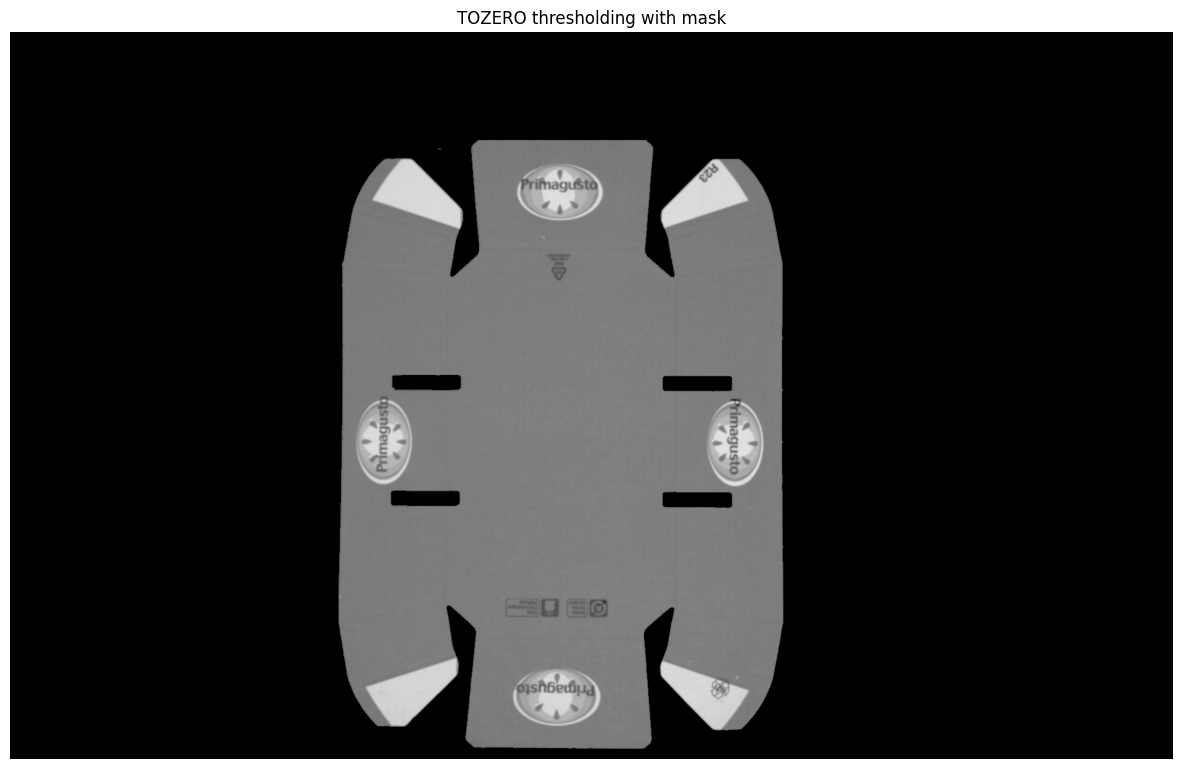

In [53]:
# We create a mask of the same size as the original image
mask = np.zeros_like(udst_crop_img, dtype=np.uint8)

# Inside the hull, we fill the mask with white
cv.fillPoly(mask, [hull_offset], 255)

# We apply the thresholding to the original image
thValue = 80
_, thTOZERO_full = cv.threshold(udst_crop_img, thValue, 255, cv.THRESH_TOZERO)

# Finally, we apply the mask to the thresholded image (we only take care of the area inside the hull)
thTOZERO_masked = cv.bitwise_and(thTOZERO_full, thTOZERO_full, mask=mask)

# The result is shown
plt.figure(figsize=(15, 10))
plt.imshow(thTOZERO_masked, cmap="gray", vmin=0, vmax=255)
plt.title("TOZERO thresholding with mask")
plt.axis("off")
plt.show()

In [54]:
# Encuentra los puntos extremos
topmost    = tuple(hull_offset[hull_offset[:,:,1].argmin()][0])
bottommost = tuple(hull_offset[hull_offset[:,:,1].argmax()][0])
leftmost   = tuple(hull_offset[hull_offset[:,:,0].argmin()][0])
rightmost  = tuple(hull_offset[hull_offset[:,:,0].argmax()][0])

print("Punto más arriba:", topmost)
print("Punto más abajo:", bottommost)
print("Punto más a la izquierda:", leftmost)
print("Punto más a la derecha:", rightmost)


# Copiamos la imagen original para dibujar los puntos
th_COPy_COLOR = cv.cvtColor(thTOZERO_masked, cv.COLOR_GRAY2BGR)

# Opcional: dibuja los puntos en la imagen
for pt, color in zip([topmost, bottommost, leftmost, rightmost], [(255,0,0),(0,255,0),(0,0,255),(255,255,0)]):
    cv.circle(th_COPy_COLOR, pt, 8, color, -1)

# plt.figure(figsize=(15,10))
# plt.title("Puntos extremos del contorno")
# plt.imshow(cv.cvtColor(th_COPy_COLOR, cv.COLOR_BGR2RGB))
# plt.axis("off")
# plt.show()

Punto más arriba: (np.int64(1053), np.int64(180))
Punto más abajo: (np.int64(1051), np.int64(1184))
Punto más a la izquierda: (np.int64(543), np.int64(983))
Punto más a la derecha: (np.int64(1277), np.int64(380))


height:  1004.0019920298963
width:  949.9289447111295
Cardboard center:  (np.int64(910), np.int64(682))


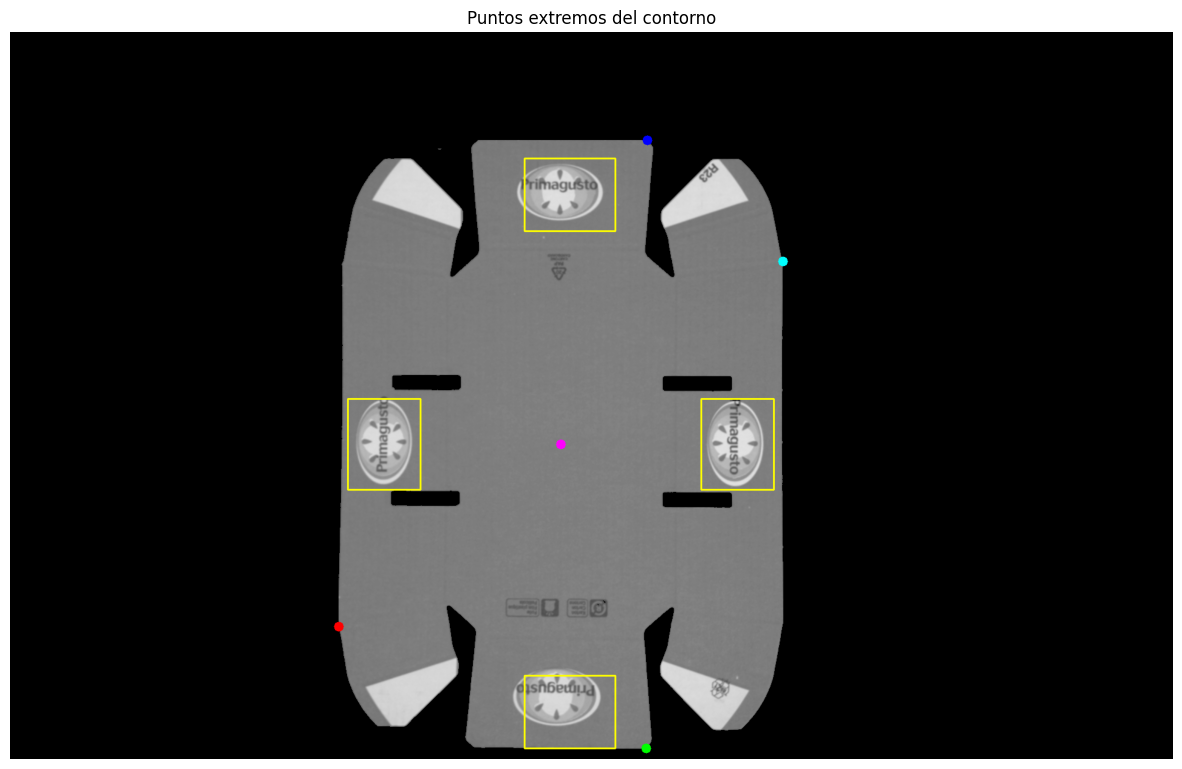

In [55]:
# Cardboard dimensions approximated
height = np.linalg.norm(np.array(topmost) - np.array(bottommost))
width = np.linalg.norm(np.array(leftmost) - np.array(rightmost))

print("height: ", height)
print("width: ", width)

# We are going to create 4 rectangles in the middle of each coordinate
# PARAMETER TO BE TUNED
rect_h = 150
rect_w = 120
margin = 15

# We find the center of the cardboard
cardboardCenter = tuple([(leftmost[0] + rightmost[0])//2, (topmost[1] + bottommost[1])//2])
print("Cardboard center: ", cardboardCenter)

# We draw the rectangles (using the left corner of the rectangle)
rectangles = [
    (leftmost[0] + margin, cardboardCenter[1] + rect_h//2 , rect_w, rect_h),
    (rightmost[0] - rect_w - margin, cardboardCenter[1] + rect_h//2, rect_w, rect_h),
    (cardboardCenter[0] - rect_w//2, topmost[1] + rect_h, rect_h, rect_w),
    (cardboardCenter[0] - rect_w//2, bottommost[1], rect_h, rect_w)
]

# We draw the rectangles in the image
for (x, y, w, h) in rectangles:
    cv.rectangle(th_COPy_COLOR, (x, y), (x + w, y - h), (0, 255, 255), 2)
for (x, y, w, h) in rectangles:
    cv.rectangle(th_COPy_COLOR, (x, y), (x + w, y - h), (0, 255, 255), 2)

cv.circle(th_COPy_COLOR, cardboardCenter, 8, (255,0,255), -1)

plt.figure(figsize=(15,10))
plt.title("Puntos extremos del contorno")
plt.imshow(cv.cvtColor(th_COPy_COLOR, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

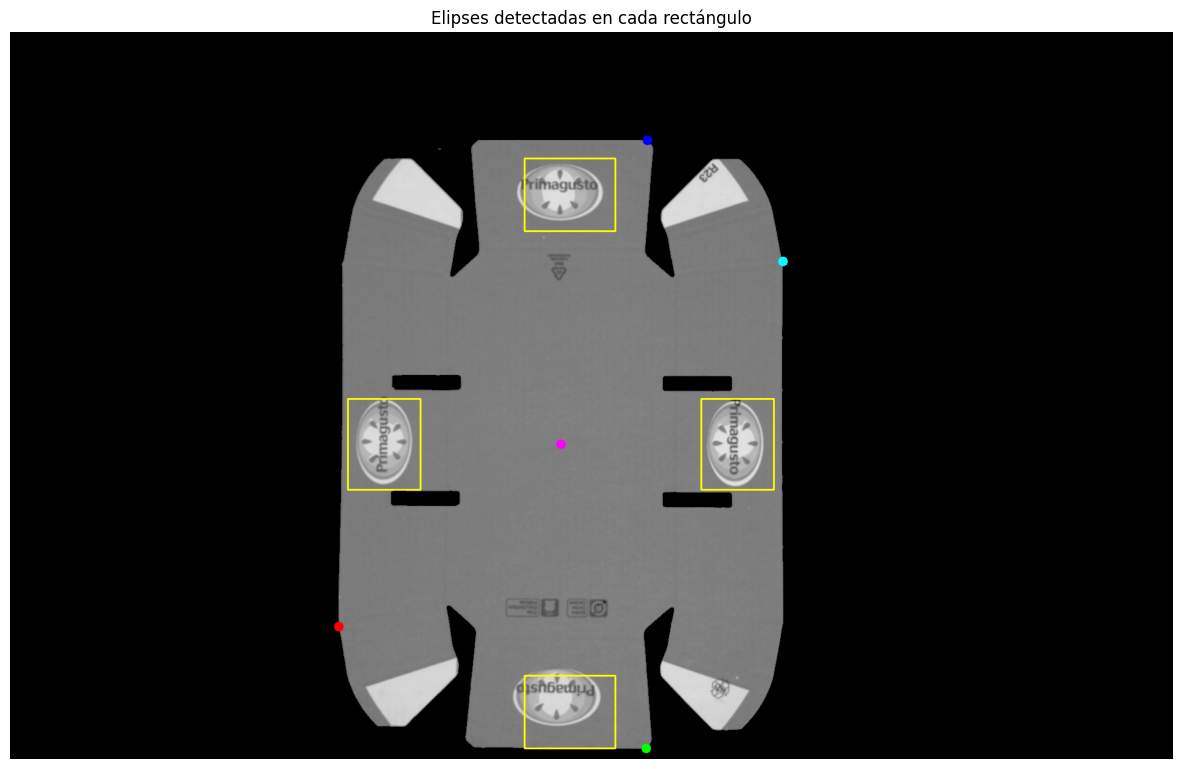

In [56]:
for (x, y, w, h) in rectangles:
    # Recorta la región del rectángulo (cuidado con los límites)
    x1, y1 = max(x, 0), max(y - h, 0)
    x2, y2 = min(x + w, thTOZERO_masked.shape[1]), min(y, thTOZERO_masked.shape[0])
    region = thTOZERO_masked[y1:y2, x1:x2].copy()

    # Invertimos la imagen para que lo oscuro sea blanco (mejor para encontrar elipses oscuras)
    region_inv = cv.bitwise_not(region)

    # Umbral para resaltar lo más oscuro
    _, region_bin = cv.threshold(region_inv, 130, 255, cv.THRESH_BINARY)

    # Encuentra los contornos en la región binarizada
    contours, _ = cv.findContours(region_bin, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    if contours:
        # Selecciona el contorno de mayor área
        max_contour = max(contours, key=cv.contourArea)
        #if len(max_contour) >= 5:
        #    ellipse = cv.fitEllipse(max_contour)
        #    (xc, yc), (d1, d2), angle = ellipse
        #    # Ajusta la posición a la imagen original
        #    center = (int(xc + x1), int(yc + y1))
        #    axes = (int(d1/2), int(d2/2))
        #    cv.ellipse(th_COPy_COLOR, center, axes, angle, 0, 360, (0,0,255), 2)
        #    cv.circle(th_COPy_COLOR, center, 2, (0,255,0), 3)
        #    print(f"Elipse detectada en rectángulo ({x1},{y1},{x2},{y2}): centro={center}, ejes={axes}, ángulo={angle:.1f}")
        #else:
        #    print(f"Contorno muy pequeño para ajustar elipse en rectángulo ({x1},{y1},{x2},{y2})")
    else:
        print(f"No se encontró contorno oscuro en rectángulo ({x1},{y1},{x2},{y2})")

plt.figure(figsize=(15,10))
plt.title("Elipses detectadas en cada rectángulo")
plt.imshow(cv.cvtColor(th_COPy_COLOR, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

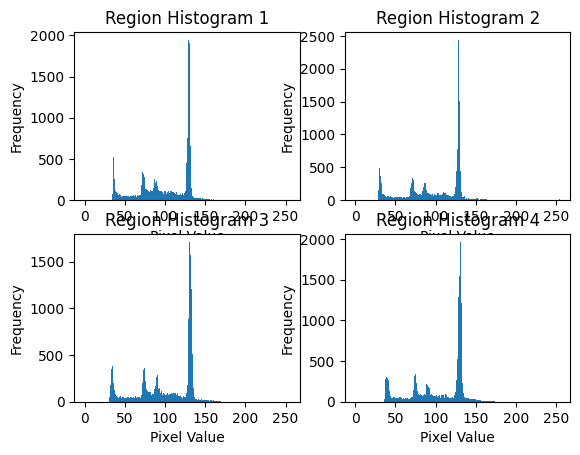

In [57]:
j = 1
for (x, y, w, h) in rectangles:
    # Recorta la región del rectángulo (cuidado con los límites)
    x1, y1 = max(x, 0), max(y - h, 0)
    x2, y2 = min(x + w, thTOZERO_masked.shape[1]), min(y, thTOZERO_masked.shape[0])
    region = thTOZERO_masked[y1:y2, x1:x2].copy()

    # Invertimos la imagen para que lo oscuro sea blanco (mejor para encontrar elipses oscuras)
    region_inv = cv.bitwise_not(region)

    plt.subplot(2,2,j)
    plt.hist(region_inv.ravel(), bins=256, range=(0, 255))
    plt.xticks(np.arange(0, 256, 50))
    plt.title("Region Histogram " + str(j))
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    j += 1